In [109]:
import torchvision
import numpy as np
import timm
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from collections import Counter
import torch
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.stats import entropy

In [110]:
# define the transformation for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# Pick only the first 1000 samples so that my laptop can run it in a reasonable time
dataset = Subset(dataset, np.arange(1000))

dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

# Load pre-trained SimCLR ResNet50 model
model = timm.create_model("resnet50_simclr_cifar10", pretrained=True)

In [111]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT feature extractor and model
model_name = "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
improved_model = ViTModel.from_pretrained(model_name).to(device)

# Define transformation (using ViT feature extractor normalization)
transform_improved = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load CIFAR-10 dataset
dataset_improved = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform_improved, download=True)

# Pick only the first 1000 samples to reduce memory usage
dataset_improved = Subset(dataset_improved, np.arange(1000))
dataloader_improved = DataLoader(dataset_improved, batch_size=128, shuffle=False, num_workers=2)

/Users/felixanderton/Documents/Coursework/5CCSAMLF-CW-2/.venv/lib/python3.13/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at aaraki/vit-base-patch16-224-in21k-finetuned-cifar10 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def typiclust(unlabeled_loader, model, budget, labeled_indices=None):
    model.eval()
    penultimate_features = []
    labels = []

    # Generates the embeddings for each image
    with torch.no_grad():
        for images, targets in unlabeled_loader:
            if isinstance(images, list):
                images = torch.stack(images)
            images = images.to(next(model.parameters()).device)       

            # Extract penultimate features
            modules = list(model.children())[:-1]
            backbone = torch.nn.Sequential(*modules)
            feats = backbone(images)
            labels.append(targets.numpy())

            penultimate_features.append(feats.cpu().numpy())

    # Concatenate features
    features = np.concatenate(penultimate_features, axis=0)
    labels = np.concatenate(labels, axis=0)

    penultimate_features = np.vstack(penultimate_features)

    # Optimize K-Means Clustering
    labeled_count = len(labeled_indices) if labeled_indices is not None else 0
    n_clusters = max(budget, labeled_count + budget)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(penultimate_features)

    # Initialise typicality score array
    typicality_scores = np.zeros(len(penultimate_features))

    # Loops over each cluster to compute typicality
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) == 0:
            continue

        cluster_points = penultimate_features[cluster_indices]
        k_neighbors = 20

        # Ensure k_neighbors is valid
        k_neighbors = min(k_neighbors, len(cluster_points) - 1)

        # Compute Nearest Neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='auto').fit(cluster_points)
        distances, _ = nbrs.kneighbors(cluster_points)

        # Compute inverse mean distance for typicality
        mean_distances = distances[:, 1:].mean(axis=1)  # Exclude self-distance
        typicality_scores[cluster_indices] = 1.0 / (mean_distances + 1e-9)

    # Select the most typical examples from the largest uncovered clusters
    uncovered_clusters = set(range(n_clusters))
    if labeled_indices is not None:
        labeled_clusters = set(cluster_labels[idx] for idx in labeled_indices)
        uncovered_clusters -= labeled_clusters

    uncovered_clusters = sorted(uncovered_clusters, key=lambda c: np.sum(cluster_labels == c), reverse=True)
    selected_clusters = uncovered_clusters[:budget]

    selected_indices = []
    for c in selected_clusters:
        cluster_idx = np.where(cluster_labels == c)[0]
        if labeled_indices is not None:
            cluster_idx = [idx for idx in cluster_idx if idx not in labeled_indices]
        if len(cluster_idx) == 0:
            continue

        # Pick the most typical point in each selected cluster
        best_idx = cluster_idx[np.argmax(typicality_scores[cluster_idx])]
        selected_indices.append(best_idx)

    selected_indices = selected_indices[:budget]  # Ensure exact budget size

    return features, labels, selected_indices, cluster_labels

In [ ]:
def typiclust_improved(unlabeled_loader, model, budget, labeled_indices=None):
    # Set model to evaluation mode
    model.eval()
    
    # Ensure device is defined
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Extract features
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in unlabeled_loader:
            images = images.to(device)

            # Forward pass through ViT to extract embeddings
            outputs = model(images).last_hidden_state[:, 0, :]  # CLS token embedding
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    # Concatenate features
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Compute number of clusters
    n_clusters = 10

    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(features)

    # Compute typicality scores
    typicality_scores = np.zeros(len(features))

    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) == 0:
            print(f"⚠️ Skipping empty cluster {cluster}.")
            continue

        cluster_points = features[cluster_indices]
        
        if len(cluster_points) <= 1:
            print(f"⚠️ Cluster {cluster} has {len(cluster_points)} samples, skipping nearest neighbors computation.")
            continue

        k_neighbors = min(20, len(cluster_points) - 1)

        # Compute Nearest Neighbors
        nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='auto').fit(cluster_points)
        distances, _ = nbrs.kneighbors(cluster_points)

        # Compute inverse mean distance for typicality
        mean_distances = distances[:, 1:].mean(axis=1) if distances.shape[1] > 1 else np.zeros(len(distances))
        typicality_scores[cluster_indices] = 1.0 / (mean_distances + 1e-9)

    # Select the most typical examples from the largest uncovered clusters
    uncovered_clusters = set(range(n_clusters))
    if labeled_indices is not None:
        labeled_clusters = set(cluster_labels[idx] for idx in labeled_indices)
        uncovered_clusters -= labeled_clusters

    uncovered_clusters = sorted(uncovered_clusters, key=lambda c: np.sum(cluster_labels == c), reverse=True)
    selected_indices = []
    
    while len(selected_indices) < budget:
        for c in uncovered_clusters:
            if len(selected_indices) >= budget:
                break  # Stop once the budget is met
            
            cluster_idx = np.where(cluster_labels == c)[0]
            if labeled_indices is not None:
                cluster_idx = [idx for idx in cluster_idx if idx not in labeled_indices and idx not in selected_indices]

            if len(cluster_idx) == 0:
                continue

            # Pick the most typical point remaining in this cluster
            best_idx = cluster_idx[np.argmax(typicality_scores[cluster_idx])]
            selected_indices.append(best_idx)

    # Ensure the correct number of selected samples
    if len(selected_indices) < budget:
        print(f"⚠️ Warning: Only {len(selected_indices)} samples selected out of {budget}.")

    return features, labels, selected_indices, cluster_labels

In [ ]:
def plot_tsne(features, labels, selected_indices):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))

    # Scatter plot for all images (colored by class)
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1], 
        c=labels, cmap="tab10", alpha=0.7, edgecolors="none"
    )

    # Highlight selected images as black 'x' markers
    plt.scatter(
        reduced_features[selected_indices, 0], reduced_features[selected_indices, 1],
        c='black', marker='x', s=100, label="Selected Images"
    )

    # Legend and Labels
    plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    plt.legend(loc="upper left")
    plt.title("t-SNE Visualisation of Embeddings (Selected Images Highlighted)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [ ]:
def plot_class_diversity(labels, selected_indices):
    # Extract selected class labels
    selected_classes = [labels[idx] for idx in selected_indices]

    # Count occurrences of each class
    selected_counts = Counter(selected_classes)

    # Convert counts to ordered lists
    all_classes = range(10)
    selected_freq = [selected_counts.get(cls, 0) for cls in all_classes]

    # Set up bar width for side-by-side comparison
    bar_width = 0.75
    x = np.arange(len(all_classes))

    # Create the bar chart
    plt.figure(figsize=(5, 5))
    plt.bar(x, selected_freq, width=bar_width, color="blue", label="TPC_RP Selection")

    # Labels and formatting
    plt.xticks(ticks=x, labels=all_classes)
    plt.legend()
    plt.xlabel("Class")
    plt.ylabel("Number of Images Selected")
    plt.title("Class Diversity: TPC_rp")
    plt.show()

In [ ]:
def evaluate_clustering(labels, cluster_labels):
    nmi = normalized_mutual_info_score(labels, cluster_labels)
    ari = adjusted_rand_score(labels, cluster_labels)
    
    print(f"✅ Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"✅ Adjusted Rand Index (ARI): {ari:.4f}")
    
    return {"NMI": nmi, "ARI": ari}


def compute_class_diversity(labels, selected_indices, num_classes=10):
    # Extract selected class labels from indices
    selected_classes = np.array([labels[idx] for idx in selected_indices])

    # Count occurrences of each class
    class_counts = np.bincount(selected_classes, minlength=num_classes)

    # Convert counts to probabilities
    probs = class_counts / class_counts.sum()

    # Compute entropy (ignore zero probabilities to avoid log(0))
    diversity_score = entropy(probs, base=2)

    # Normalize by max entropy log2(num_classes)
    max_entropy = np.log2(num_classes)
    normalized_diversity_score = diversity_score / max_entropy if max_entropy > 0 else 0

    return normalized_diversity_score  # Now guaranteed to be between 0 and 1

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


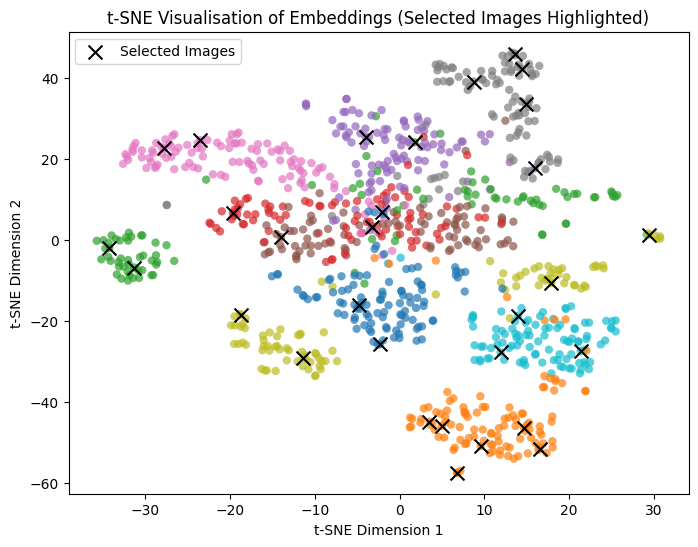

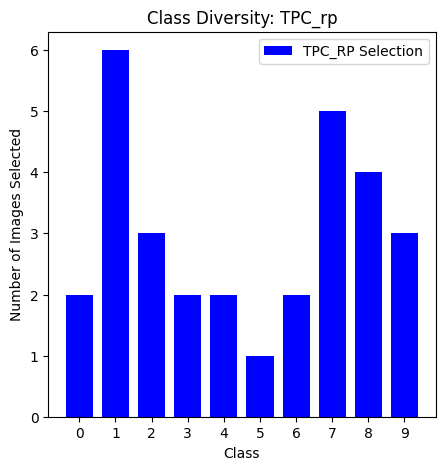

In [117]:
features, labels, selected_indices, cluster_labels = typiclust(dataloader, model, 30)
plot_tsne(features, labels, selected_indices)
plot_class_diversity(labels, selected_indices)

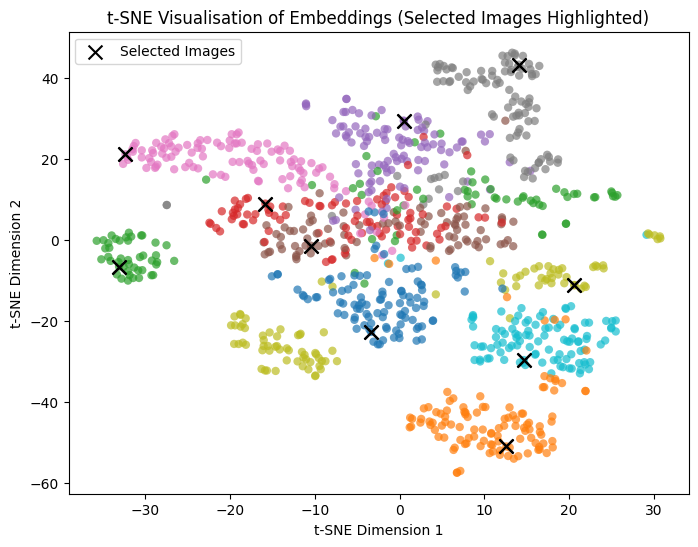

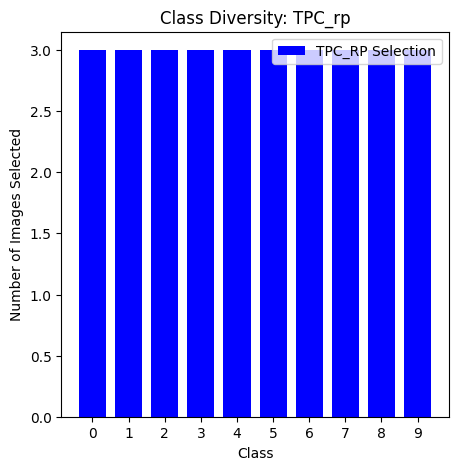

In [ ]:
improved_features, improved_labels, improved_selected_indices, improved_cluster_labels = typiclust_improved(dataloader_improved, improved_model, 30)
plot_tsne(improved_features, improved_labels, improved_selected_indices)
plot_class_diversity(dataset_improved, improved_selected_indices)

In [108]:
clustering_accuracy = evaluate_clustering(labels, cluster_labels)
improved_clustering_accuracy = evaluate_clustering(improved_labels, improved_cluster_labels)

diversity_score = compute_class_diversity(labels, selected_indices)
improved_diversity_score = compute_class_diversity(improved_labels, improved_selected_indices)

print(f"Diversity score: {diversity_score}, Improved diversity score: {improved_diversity_score}")

✅ Normalized Mutual Information (NMI): 0.5828
✅ Adjusted Rand Index (ARI): 0.2656
✅ Normalized Mutual Information (NMI): 0.9800
✅ Adjusted Rand Index (ARI): 0.9791
Diversity score: 0.9490224219555417, Improved diversity score: 1.0
